In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np, yaml, cPickle as pickle
import data_io
import pandas as pd
from copy import copy
from sklearn.cross_validation import train_test_split

golden = True

## Load in richness labels and spectrograms and biotic predictions

In [67]:
richness = pd.read_csv(
    data_io.large_base + '../diversity_labelled_data/resultAndSiteFiles/6SitesWith90Minutes.csv')

richness_files = set(xx.split('.')[0] for xx in richness.File)

In [68]:
fname_to_richness = {}
for idx, row in richness.iterrows():
    
    fname_to_richness[row['File'].split('.')[0]] = sum(
        yy for xx, yy in row.iteritems() if xx != u'File')

In [69]:
# load in the spectrograms as computed
specs = {}
for fname in richness_files:
    specs[fname] = pickle.load(open('tmp/specs/' + fname +  '.pkl'))

In [29]:
# load in the predictions
preds = {}
for fname in richness_files:
    preds[fname] = pickle.load(open('tmp/preds/' + fname +  '_biotic.pkl'))

## Train test split by *site*

In [23]:
sites = list(set(xx.split('_')[0] for xx in richness_files))
test_sites = sites[0:1]
train_sites = sites[1:]

In [24]:
test_files = [xx for xx in richness_files if xx.split('_')[0] in test_sites]
train_files = [xx for xx in richness_files if xx.split('_')[0] in train_sites]

## Compute features from spectrograms

In [31]:
def compute_ACI(spectro,j_bin):
    """
    Compute the Acoustic Complexity Index from the spectrogram of an audio signal.
    Reference: Pieretti N, Farina A, Morri FD (2011) A new methodology to infer 
    the singing activity of an avian community: the Acoustic Complexity Index (ACI). 
    Ecological Indicators, 11, 868-873.

    Ported from the soundecology R package.
    spectro: the spectrogram of the audio signal
    j_bin: temporal size of the frame (in samples)
    """

    #times = range(0, spectro.shape[1], j_bin) # relevant time indices
    times = range(0, spectro.shape[1]-10, j_bin) # alternative time indices to follow the R code

    jspecs = [np.array(spectro[:,i:i+j_bin]) for i in times]  # sub-spectros of temporal size j

    aci = [sum((np.sum(abs(np.diff(jspec)), axis=1) / np.sum(jspec, axis=1))) for jspec in jspecs] 	# list of ACI values on each jspecs
    main_value = sum(aci)
    temporal_values = aci

    return main_value, temporal_values # return main (global) value, temporal values


def ACI_inspired_features(spec):
    return np.abs(np.diff(spec)).sum(axis=1)# / np.sum(spec, axis=1)


def compute_features(_spec, annot):
    spec = copy(_spec)
    spec -= np.median(spec, 1, keepdims=True)
    just_biotic_normed = spec[:, annot > 0.5]
    just_biotic_unnormed = _spec[:, annot > 0.5]
    
    if just_biotic_normed.size == 0:
        return np.zeros(161)
    X = []
    X.append(just_biotic_normed.mean(1))
    X.append(just_biotic_normed.std(1))
    X.append(just_biotic_unnormed.mean(1))
    X.append(just_biotic_unnormed.std(1))
    X.append(just_biotic_unnormed.shape[1])
    X.append(ACI_inspired_features(just_biotic_unnormed))
    tmp = np.hstack(X)
    return tmp


def compute_all_feats(specs, fnames, annots):    
    X = []
    for fname in fnames:#, annots):
        X.append(compute_features(specs[fname], preds[fname][:, 1]))
#         print X[-1].shape
    return np.vstack(X)

In [ ]:
#test_annots = [np.zeros(xx.shape[1]) for xx in test_specs]
test_X = compute_all_feats(specs, test_files, None)
train_X = compute_all_feats(specs, train_files, None)

test_y = np.hstack(fname_to_richness[fname] for fname in test_files)
train_y = np.hstack(fname_to_richness[fname] for fname in train_files)

print train_X.shape, train_y.shape, test_X.shape, test_y.shape

## Do machine learning

In [64]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(25, max_depth=25)
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)

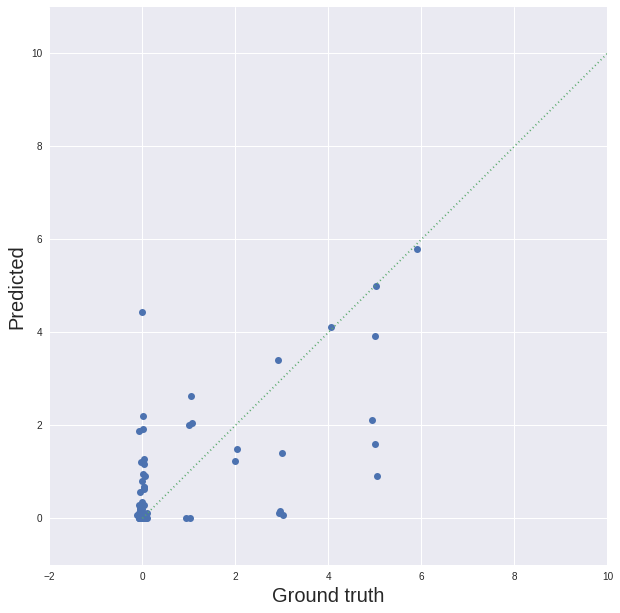

In [74]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plt.plot(test_y + np.random.randn(test_y.shape[0]) * 0.05 , pred_y, 'o')
plt.xlabel('Ground truth', fontsize=20)
plt.ylabel('Predicted', fontsize=20)
plt.axis('equal')
plt.plot([0, 10], [0, 10], ':')

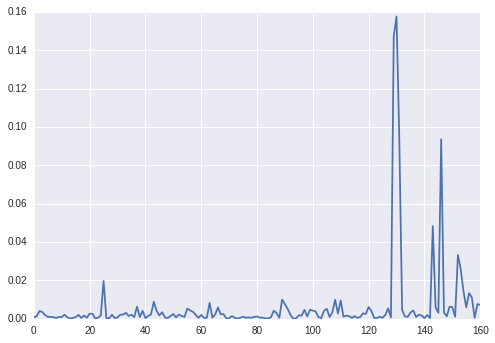

In [66]:
plt.plot(rf.feature_importances_)